#### autoreload modules and utilities

In [1]:
%load_ext autoreload
%autoreload 2

#### import all neceesary libraries/packages

In [2]:
import joblib

import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.pipeline import Pipeline 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score as calculate_f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold 

#### Utility functions

In [41]:
## utilities
# from utils import clean_text

import string

from sklearn.base import TransformerMixin

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
# wordnet_lemmatizer.lemmatize

def clean_text(text: str, lemmatize = None) -> str:
    # removes upper cases
    text = text.lower()
    
    # removes punctuation
    for char in string.punctuation:
        text = text.replace(char, "")
    
    #lematize the words and join back into string text
    if lemmatize is not None:
        text = " ".join([lemmatize(word) for word in word_tokenize(text)])
        
    return text

def calculate_sparsity(matrix):
    non_zero = np.count_nonzero(matrix)
    total_val = np.product(matrix.shape)
    sparsity = (total_val - non_zero) / total_val
    return sparsity

def data_isvalid(text, min_character_size, max_character_size):
    return min_character_size <= len(clean_text(text)) <= max_character_size 

def get_pipeline(count_vectorizer, classifier, rwi_transformer=None, tfidf_transformer=None):
    models = [('vectorizer', count_vectorizer)]
    
    if tfidf_transformer is not None:
        models.append(('tfidf_transformer', tfidf_transformer))
        
    models.append(
        ('dense', DenseTransformer(count_vectorizer=count_vectorizer))
    )
    
    if rwi_transformer is not None:
        models.append(('rwi_transformer', rwi_transformer))
    
    models.append(('classifier', classifier))
    return Pipeline(models)

def get_model(tfidf=False, rwi=False, depth=1, stop_words="english", return_rwi_transformer=False):
    count_vectorizer = CountVectorizer(stop_words=stop_words)
    tfidf_transformer = TfidfTransformer() if tfidf else None
    rwi_transformer = RWITransformer(depth=depth) if rwi else None
    classifier = MultinomialNB()
    
    if return_rwi_transformer:
        return get_pipeline(count_vectorizer, classifier, rwi_transformer, tfidf_transformer), rwi_transformer
    
    # normal model
    return get_pipeline(count_vectorizer, classifier, rwi_transformer, tfidf_transformer)

class DenseTransformer(TransformerMixin):
    def __init__(self, count_vectorizer):
        self.count_vectorizer = count_vectorizer
        
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return pd.DataFrame(data=X.todense(), columns=self.count_vectorizer.get_feature_names())
    
    def __str__(self):
        return "DenseTransformer()"
    
    def __repr__(self):
        return self.__str__()
    
class RWITransformer(TransformerMixin):
    def __init__(self, depth=1):
        self.depth = depth
    
    @staticmethod
    def _max_weight(x, pbar, word_word_pr_distr_prime):
        pbar.update(1)
        return word_word_pr_distr_prime.apply(lambda y: x*y, axis=0).max(0)
    
    @staticmethod
    def _sum_weight(x, pbar, word_word_pr_distr_prime):
        pbar.update(1)
        return word_word_pr_distr_prime.apply(lambda y: x*y, axis=0).sum(0)

    def fit(self, X, y=None, **fit_params):
        word_doc_count = X.sum(0)
        word_word_pr_distr = pd.DataFrame(data=0.0, columns=X.columns, index=X.columns)
        
        print("creating term-term co-occurence matrix")
        for column in tqdm(X.columns):
            pxy = X[X[column] > 0].sum(0) / word_doc_count[column]
            word_word_pr_distr[column] = pxy * (word_doc_count[column] / word_doc_count)
        
        print(f"creating a richer term-term co-occurence matrix using recursive term-term pr, depth = {self.depth}")
        word_word_pr_distr_prime = word_word_pr_distr.copy()
        with tqdm(total=len(X.columns)*self.depth) as pbar:
            for _ in range(self.depth):
                word_word_pr_distr_prime = word_word_pr_distr_prime.apply(
                    self._max_weight, axis=1, args=(pbar, word_word_pr_distr_prime)
                )
                
        
        # scale to integers
        min_value = word_word_pr_distr_prime[word_word_pr_distr_prime > 0].min().min()
        word_word_pr_distr_prime_scale = word_word_pr_distr_prime / min_value

        # to int and aproximated to nearest integer
        word_word_pr_distr_prime_scale = np.rint(word_word_pr_distr_prime_scale).astype(int)
        
        # self.word_word_pr_distr = word_word_pr_distr
        # self.word_word_pr_distr_prime = word_word_pr_distr_prime
        self.word_word_pr_distr_prime_scale = word_word_pr_distr_prime_scale
        return self

    def transform(self, X, y=None, **fit_params):
        print("running transform ...")
        with tqdm(total=X.shape[0]) as pbar:
            X = X.apply(self._sum_weight, axis=1, args=(pbar, self.word_word_pr_distr_prime_scale))
        return X
    
    def __str__(self):
        return "DenseTransformer()"
    
    def __repr__(self):
        return self.__str__()

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Load Data

In [4]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
categories = all_docs.target_names

In [5]:
print(all_docs.data[0])



I think that domestication will change behavior to a large degree.
Domesticated animals exhibit behaviors not found in the wild.  I
don't think that they can be viewed as good representatives of the
wild animal kingdom, since they have been bred for thousands of years
to produce certain behaviors, etc.


### Create Dataframe

In [6]:
data = pd.DataFrame(
    data={
        "text":all_docs.data, 
        "label":all_docs.target
    }
)

data.head()

,text,label
0,\n\nI think that domestication will change beh...,0
1,"\nI don't like this comment about ""Typical"" th...",3
2,\n<apparently you're not a woman - my husband ...,1
3,"While not exactly a service incident, I had a ...",1
4,\n\nI think I can. Largely as a result of effo...,2


### Label Frequency

1    594
2    593
3    564
0    480
Name: label, dtype: int64



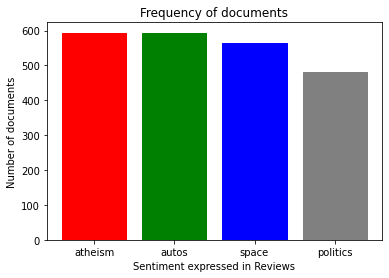

In [7]:
print(data["label"].value_counts())
print()

barlist = plt.bar(categories, data["label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

The Dataset labels needs to be balanced

# Select Valid Data

In [8]:
max_size_per_class = 40

# remove long text
indices = data["text"].apply(data_isvalid, args=(160, 256))
data = data[indices]

# make classes balanced
class_indices = []

for index in range(4):
    class_indices.append(np.where((data["label"] == index))[0])
    
size_per_class = min(max_size_per_class, min(map(len, class_indices)))
indices = np.concatenate([class_ids[:size_per_class] for class_ids in class_indices])

data = data.iloc[indices]

data.head()

,text,label
19,"\n\n\tI agree, we spend too much energy on the...",0
50,\n\n Could you explain what any of the above p...,0
164,\nUh oh. This looks a bit too much like Bobby...,0
204,Could you explain what any of this pertains to...,0
215,\n\nGood question. I'm sure some biologist co...,0


In [9]:
print(data.iloc[0]["text"])



	I agree, we spend too much energy on the nonexistance of God.

--


       "Satan and the Angels do not have freewill.  
        They do what god tells them to do. "


3    40
2    40
1    40
0    40
Name: label, dtype: int64



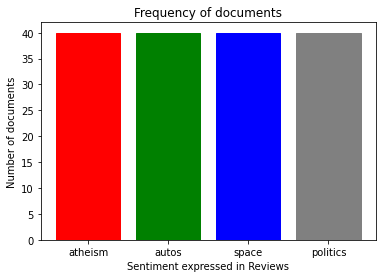

In [10]:
print(data["label"].value_counts())
print()

barlist = plt.bar(categories, data["label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

### initialize input and output

In [11]:
X = data["text"]
y = data['label']

### initialize recursive word infer model

In [12]:
# rwi_count_model, rwi_transformer = get_model(rwi=True, return_rwi_transformer=True)

In [13]:
# rwi_count_model.fit(X, y)

In [14]:
# wwds = calculate_sparsity(rwi_transformer.word_word_pr_distr)
# wwdm = rwi_transformer.word_word_pr_distr.mean().mean()
# wwdstd = rwi_transformer.word_word_pr_distr.mean().mean()

# wwdps = calculate_sparsity(rwi_transformer.word_word_pr_distr_prime)
# wwdpm = rwi_transformer.word_word_pr_distr_prime.mean().mean()
# wwdpstd = rwi_transformer.word_word_pr_distr_prime.mean().std()

# print("                                           | sparsity | mean   | std")
# print("-----------------------------------------------------------------------")
# print(f"word_word_pr_distr matrix sparsity         | {wwds:.4f}   | {wwdm:.4f} | {wwdstd:.4f}")
# print(f"word_word_pr_distr_prime matrix sparsity   | {wwdps:.4f}   | {wwdpm:.4f} | {wwdpstd:.4f}")

In [15]:
# word = "space"
# given_word1 = "science"
# given_word2 = "god"
# print(
#     f"{word:>16s} | {given_word1:16s}", 
#     f"{rwi_transformer.word_word_pr_distr[word][given_word1]:.4f}", 
#     f"{rwi_transformer.word_word_pr_distr_prime[word][given_word1]:.4f}"
# )
# print(
#     f"{word:>16s} | {given_word2:16s}", 
#     f"{rwi_transformer.word_word_pr_distr[word][given_word2]:.4f}", 
#     f"{rwi_transformer.word_word_pr_distr_prime[word][given_word2]:.4f}"
# )

In [16]:
# joblib.dump(cv_NB, "models/multinomial_naive_bayes_with_count_vectorizer.joblib")

In [17]:
# y_pred = rwi_count_model.predict(X) #predict testing data
# print(classification_report(y, y_pred))

In [18]:
# count_model = get_model()
# count_model.fit(X, y)

# y_pred = count_model.predict(X) #predict testing data
# print(classification_report(y, y_pred))

### Initialize models

In [47]:
# normal model
count_model = get_model(stop_words=None)
count_sw_model = get_model(stop_words="english")

tfidf_model = get_model(tfidf=True, stop_words=None)
tfidf_sw_model = get_model(tfidf=True, stop_words="english")

# model with inference
depth = 3

rwi_count_model = get_model(rwi=True, depth=depth, stop_words=None)
rwi_count_sw_model = get_model(rwi=True, depth=depth, stop_words="english")

rwi_tfidf_model = get_model(tfidf=True, depth=depth, rwi=True, stop_words=None)
rwi_tfidf_sw_model = get_model(tfidf=True, depth=depth, rwi=True, stop_words="english")

models = [count_model, count_sw_model, tfidf_model, tfidf_sw_model, rwi_count_model, rwi_count_sw_model, rwi_tfidf_model, rwi_tfidf_sw_model]

### Running Cross validation on all Models

In [48]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=100) 
# skf.get_n_splits(X, y)

f1_scores, accuracies = [], []
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index] 
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    f1_scores.append([])
    accuracies.append([])
    
    for model in models:
        model.fit(x_train_fold, y_train_fold)
        y_pred = model.predict(x_test_fold)

        accuracy = accuracy_score(y_test_fold, y_pred)
        f1_score = calculate_f1_score(y_test_fold, y_pred, average='weighted')
        
        f1_scores[-1].append(f1_score)
        accuracies[-1].append(accuracy)

creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...



creating term-term co-occurence matrix



creating a richer term-term co-occurence matrix using recursive term-term pr, depth = 3



running transform ...



running transform ...


In [49]:
accuracy = pd.DataFrame(
    data=np.array(accuracies), 
    columns=["count_model", "count_sw_model", "tfidf_model", "tfidf_sw_model", "rwi_count_model", "rwi_count_sw_model", "rwi_tfidf_model", "rwi_tfidf_sw_model"]
)

f1_score = pd.DataFrame(
    data=np.array(f1_scores),
    columns=["count_model", "count_sw_model", "tfidf_model", "tfidf_sw_model", "rwi_count_model", "rwi_count_sw_model", "rwi_tfidf_model", "rwi_tfidf_sw_model"]
)

In [50]:
accuracy.loc["mean"] = accuracy.mean(0)

accuracy.head()

,count_model,count_sw_model,tfidf_model,tfidf_sw_model,rwi_count_model,rwi_count_sw_model,rwi_tfidf_model,rwi_tfidf_sw_model
0,0.592593,0.629630,0.629630,0.666667,0.555556,0.537037,0.555556,0.555556
1,0.377358,0.603774,0.433962,0.603774,0.509434,0.566038,0.509434,0.584906
2,0.509434,0.547170,0.490566,0.547170,0.452830,0.452830,0.490566,0.396226
mean,0.493128,0.593524,0.518053,0.605870,0.505940,0.518635,0.518519,0.512229


In [51]:
f1_score.loc["mean"] = f1_score.mean(0)

f1_score.head()

,count_model,count_sw_model,tfidf_model,tfidf_sw_model,rwi_count_model,rwi_count_sw_model,rwi_tfidf_model,rwi_tfidf_sw_model
0,0.565084,0.610656,0.605346,0.630810,0.545661,0.528931,0.545892,0.543680
1,0.371848,0.599910,0.405679,0.608255,0.512766,0.563606,0.509434,0.580961
2,0.490792,0.530556,0.471202,0.530848,0.450804,0.447580,0.486621,0.393569
mean,0.475908,0.580374,0.494076,0.589971,0.503077,0.513372,0.513982,0.506070
